# Full Width at Half Maximum (FWHM) Calculator Tool
This is a demonstration of the software tool that assists with optical alignment and focus during the streak camera calibration process. The image analyzed must be taken with an overfilled slit. It may be either a static image or swept image with a short-pulse laser.

This calibration tool fits a Gaussian curve to each line of the image and calculates the FWHM from the optimal hyperparameters.

It also produces measurements for the average FWHM of a 40-pixel swath at three points of interest along the image (25%, 50%, and 75% spatially), in accordance with procedure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import stats

The user-defined parameters allow the user to:
- Define the minimum intensity below which FWHM is not calculated
- Define swath offsets to calculate FWHM from different locations

In [2]:
# User-defined parameters:

# name of saved image
filename = 'TIF/75ms_Exp.TIF'
# define minimum intensity to calculate FWHM
cutoff = 2000
# define swath offsets
all_offset = 0
one_fourth_offset = 0
halfway_offset = 0
three_fourths_offset = 0

In [3]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

In [4]:
# fit a gaussian to each line of data to calculate fwhm
def get_fwhm(x_data, img):
    # define list for full-width half max
    fwhm = []
    
    for i in range(len(img)):
        # Retrieve the data from the image line by line
        y_data = img[i]
        # identify single peak within user-defined parameters
        peak, _ = find_peaks(y_data, height=cutoff, width=5)
        if len(peak) != 1:
            fwhm.append(None)
            continue

        # find approximate amplitude
        amp = y_data[peak[0]]

        # Fit the Gaussian curve to the data
        popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[amp, peak[0], 5])

        # if error for mean and stddev parameters is too high, reject fit
        err = sum(np.sqrt(np.diag(pcov))[1:3]) / 2
        if err > 1:
            fwhm.append(None)
            continue

        # popt contains the optimized parameters: amplitude, mean, and stddev
        amplitude_fit, mean_fit, stddev_fit = popt
        # add fwhm for this row to the list
        fwhm.append(round(2.355 * stddev_fit))
    return fwhm

In [5]:
# calculate average fwhm at regions of interest
def get_avg_fwhm(roi, fwhm):
    tot = 0
    values = 0
    for i in range(roi - 20, roi + 20):
        if fwhm[i]:
            values += fwhm[i]
            tot += 1
    return values // tot

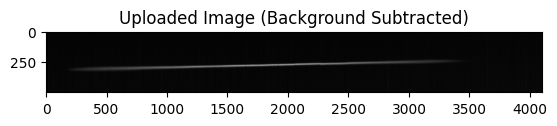

In [6]:
# import image data
fimg = Image.open(filename)
img = np.array(fimg)
# find and subtract background counts
background = stats.mode(img.reshape(len(img)*len(img[0])))[0]
img -= background
# display uploaded image (background subtracted)
plt.imshow(img, cmap ="grey")
plt.title("Uploaded Image (Background Subtracted)")
plt.show()

We can see that we have a static mode with an overfilled slit, but it is not in an orientation that the software tools was designed to read. So we need to perform an orientation check.

In [7]:
# set x-axis from image size
x = np.linspace(0, len(img[0])-1, len(img[0]))

In [8]:
# retrieve fwhm for every line
fwhm = get_fwhm(x, img)

When the image is not oriented correctly, running the software tool produced only a few values for FWHM. If this is the case, the image is rotated and the previous 2 steps are performed again.

In [9]:
# create fwhm list without None values
fwhm_filtered = [i for i in fwhm if i is not None]

# check that at least half of the fwhm values exist
if len(fwhm_filtered) < len(fwhm) / 2:
    # if not, rotate image
    img = np.rot90(img, axes=(1,0))
    # reset x-axis from new image size
    x = np.linspace(0, len(img[0])-1, len(img[0]))
    # recalculate fwhm across image
    fwhm = get_fwhm(x, img)
    # create new fwhm list without None values
    fwhm_filtered = [i for i in fwhm if i is not None]
    # if image is still not acceptable, send error message
    if len(fwhm_filtered) < len(fwhm) / 2:
        raise ValueError("Image cannot be evaluated. Please choose another image.")

Let's view a few lines to demonstrate the Gaussian fit

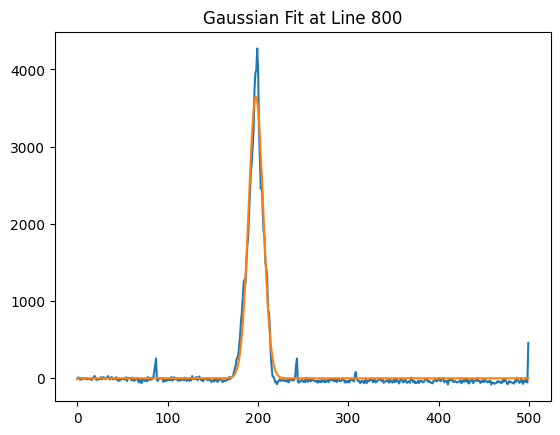

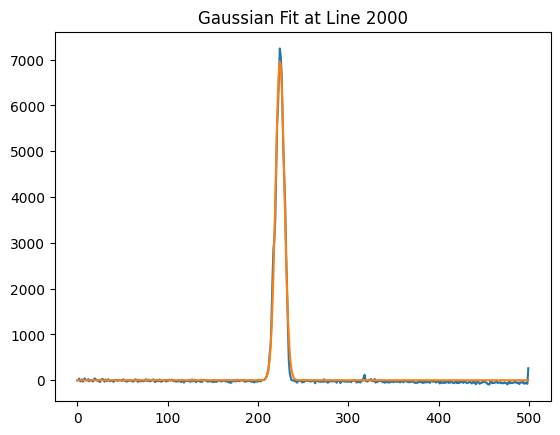

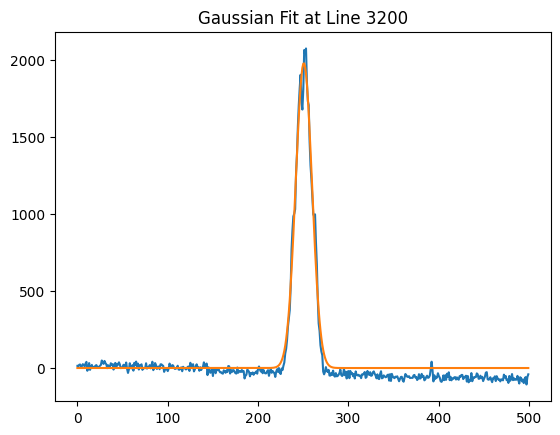

In [10]:
def view_line(line):
    # identify single peak within user-defined parameters
    peak, _ = find_peaks(img[line], height=cutoff, width=5)
    # find approximate amplitude
    amp = img[line][peak[0]]
    # Fit the Gaussian curve to the data
    popt, pcov = curve_fit(gaussian, x, img[line], p0=[amp, peak[0], 5])
    # popt contains the optimized parameters: amplitude, mean, and stddev
    amplitude_fit, mean_fit, stddev_fit = popt
    # graph curve
    y = np.array(gaussian(x, amplitude_fit, mean_fit, stddev_fit))
    plt.plot(img[line])
    plt.plot(y)
    plt.title("Gaussian Fit at Line {}".format(line))
    plt.show()
    return

view_line(800)
view_line(2000)
view_line(3200)

Now we need to find the acceptable bounds of the data to make the calculations for the areas of interest. The acceptability criteria are defined by the user.

In [11]:
# find start of acceptable data
# defined by first 5 consecutive data points
start = 0
end = 0
count = 0
for i in range(len(fwhm)):
    if fwhm[i]:
        count += 1
    else:
        count = 0
    if count == 5:
        start = i
        break

# find end of acceptable data
# defined by last 5 consecutive data points
count = 0
for i in reversed(range(len(fwhm))):
    if fwhm[i]:
        count += 1
    else:
        count = 0
    if count == 5:
        end = i
        break

Then we define the areas of interest. The positions of the areas of interest are generally at 25%, 50%, and 75% of the length of the acceptable data, but they may be adjusted by the user.

In [12]:
# find 25%, 50%, and 75% swaths of the data
one_fourth = int((3*start + end) / 4)
halfway = int((start + end) / 2)
three_fourths = int((start + 3*end) / 4)

# apply user-defined swath offsets
offsets = [one_fourth_offset + all_offset,
           halfway_offset + all_offset,
           three_fourths_offset + all_offset]

one_fourth += offsets[0]
halfway += offsets[1]
three_fourths += offsets[2]

# verify swaths are within boundaries
if (one_fourth < start or one_fourth >= end or
    halfway < start or halfway >= end or
    three_fourths < start or three_fourths >= end):
    raise ValueError("Error: Cannot evaluate FWHM outside of boundaries.")

Then the information is displayed

In [13]:
# prepare offests for display information
for i in range(len(offsets)):
    if offsets[i]:
        offsets[i] = " ({} offset)".format(offsets[i])
    else:
        offsets[i] = ""

# print spatial sample information
print("25% pixel value:", one_fourth, offsets[0])
print("50% pixel value:", halfway, offsets[1])
print("75% pixel value::", three_fourths, offsets[2])

# calculate fwhm at 25%
one_fourth_fwhm = get_avg_fwhm(one_fourth, fwhm)

# calculate fwhm at 50%
halfway_fwhm = get_avg_fwhm(halfway, fwhm)

# calculate fwhm at 75%
three_fourths_fwhm = get_avg_fwhm(three_fourths, fwhm)

# print fwhm values of interest
print("FWHM at 25%:", one_fourth_fwhm)
print("FWHM at 50%", halfway_fwhm)
print("FWHM at 75%:", three_fourths_fwhm)
print("FWHM Standard Deviation:", np.std(fwhm_filtered))

25% pixel value: 1082 
50% pixel value: 1799 
75% pixel value:: 2515 
FWHM at 25%: 15
FWHM at 50% 11
FWHM at 75%: 13
FWHM Standard Deviation: 4.748767348238792


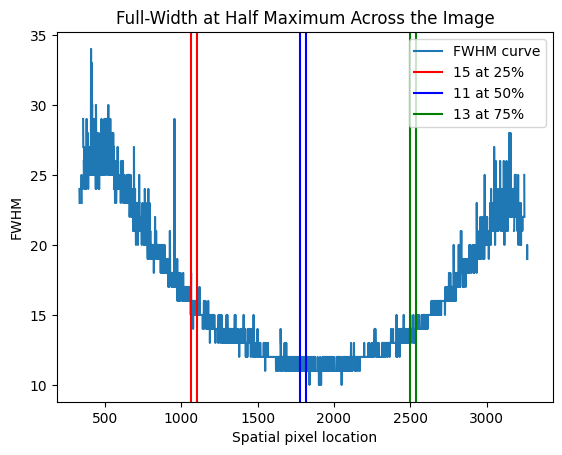

In [14]:
# Plot the results
plt.plot(fwhm, label='FWHM curve')
plt.axvline(x=one_fourth - 20, color='r')
plt.axvline(x=one_fourth + 20, color='r', label="{} at 25%".format(one_fourth_fwhm)+offsets[0])
plt.axvline(x=halfway - 20, color='b')
plt.axvline(x=halfway + 20, color='b', label="{} at 50%".format(halfway_fwhm)+offsets[1])
plt.axvline(x=three_fourths - 20, color='g')
plt.axvline(x=three_fourths + 20, color='g', label="{} at 75%".format(three_fourths_fwhm)+offsets[2])
plt.xlabel("Spatial pixel location")
plt.ylabel("FWHM")
plt.title("Full-Width at Half Maximum Across the Image")
plt.legend()
plt.show()